Tento notebook ukazuje hlavne kroky podniknute pri zatriedovani SLSP spisov. Dalsie mozne kroky su nacrtnute.
Nejedna sa o presne definovany protokol. Niektore kroky vyzaduju manualny zasah, bez ktorych bude presnost nizsia. 
Okrem popisu a ukazky krokov ukazuje notebook aj pouzitie mlflow pre lepsi prehlad pouzitych dat, modelov a ziskanych vysledkov. Pouzitie mlflow nie je v tomto momente nevyhnutne, ale je do buducna ziaduce.

Disclaimer: K priprave prostredia mam len obmedzeny vhlad, kedze u mna vsetko bezi v linuxovom prostredi. Na windowse by malo vsetko fungovat analogicky, ale nemam s tym akukolvek skusenost.


Notebook je rozdeleny do 6 casti:
1) Environment setup
2) Nacitanie a ulozenie dat
3) Preprocesovanie dat
4) Trenovanie a evaluacia modelu
5) Clustering
6) Predikcia na novych datach + kontrolne mechanizmy


# 1) ENVIRONMENT SETUP

Okrem tradicnych kniznic (sklearn, pandas, numpy) pouzivam 2 dalsie kniznice:

### 1) mlflow

Mlflow sluzi na logovanie experimentov, modelov a dat. Vysledkom je centralne miesto, kde prehladne vidime co a s akymi datami sme robili a ake vysledky dosiahli. Rovnako mozeme ukladat modely a datasety aj s popiskami. Vsetko sa da potom jednoducho nahrat.
Tieto data su ukladane na server, preto je potrebne pred pouzitim zadefinovat, kde nas server zije. Ja pouzivam dva servery - jeden lokalny v ktorom mam medzivysledky a vlastny neporiadok a jeden vzdialeny (zije za VPN na adrese 192.168.1.2). Na tento vzdialeny server ukladam len "uzitocne" data a "finalne" modely s co najdetailnejsim popisom. Ciel je tu mat malo veci do poctu, ale s vysokou prepouzitelnostou a zrozumitelnostou, idealne aj pre ludi ktori pridu po mne. Logovanie na server + vytvaranie popiskov samozrejme vytvara nejaku pracu navyse, preto tu hladam uzitocny kompromis. Styl a miera sa zrejme bude vyvijat.

Pracu s mlflow pridavam do tohto notebooku pre ilustraciu. V prvom kroku bude uzitocne si vyskusat aspon download modelov/dat. Upload vyzaduje sirsiu diskusiu, ktoru ponecham na inokedy.

Lokalny mlflow vyzaduje spustenie serveru:
mlflow server --host 127.0.0.1 --port 5001



### 2) mltools

Toto je moja vlastna kniznica, ktora ma 2 hlavne ciele 1) zjednodusit kroky, ktore robim casto 2) zjednotit sposob zapisovania dat/modelov na mlflow server
Prvy bod je strelba na pohyblivy ciel. Casto sa ukaze, ze treba robit nieco inak. V tomto smere je preto pouzitie tejto kniznice prilezitostne. Ak existuje vhodnejsi sposob ako nieco dosiahnut, nie je dovod sa mu vyhybat.
Druhy bod povazujem za dolezity pre buducu prehladnost a prepouzitelnost. Napr pouzivat repozitar dat a modelov ma zmysel len ak ich hladame a ukladame na rovnake miesto rovnakym sposobom. V tomto smere teda povazujem pouzitie tejto kniznice za velmi ziaduce. Zaroven aj tu moze dojst k zmenam, pristup mozeme prehodnotit a potom ho dalej pouzivat jednotne, aj ked v zmenenej forme.

## INSTALACIA

Instalacia prebieha rovnako ako pri akychkolvek inych knizniciach. Rozdiel je len pre mltools, ktory nie je v PyPi, preto treba odkazatna github repozitar. U mna takto:
pip install mlflow 
pip install git+https://git@github.com/OndrejGutten/mltools.git

# 2) NACITANIE A ULOZENIE DAT
Tento krok pochopitelne zavisi na formate vstupnych dat. Typicky sa jedna o csv alebo excel subor a pouzijeme pandas.read_csv alebo pandas.read_excel. V pripade csv moze byt problem s delimiterom, ktory sa sucasne nachadza v datach.

Ciel je ziskat pandas.DataFrame, ktory nasledne mozeme ulozit ako dataset v MLflow.

In [ ]:
### PRIPRAVA DAT

import pandas as pd

# nacitaj data
source_path = '/Users/ondrejgutten/Work/PISI.nosync/data/PB/PB_zredukovany_ciselnik_viacero_priloh_v5.xlsx'
df = pd.read_excel(source_path)

# ako cielove oznacenie casto pouzivam stlpec nazvany 'label' - pouzijem "kat2 (bez detailu viacerých príloh)"
df['label'] = df.iloc[:, 5].astype(str)

# Nastali pripady, kedy csv pouzival ako delimiter znak, ktory bol sucastou textu v niektorych stlpcoch. Pokial je text v poslednom stlpci je mozne pouzit funkciu mltools.utils.read_csv_first_N_fields. Tato funkcia nacita prve N stlpcov a zvysok textu spoji do posledneho stlpca. Tymto sposobom sa vyhneme problemom s delimiterom.
# napr:
# df = mltools.utils.read_csv_first_N_fields('/Users/ondrejgutten/Work/PISI.nosync/data/data_podla_vendora/SLSP_zredukovany_ciselnik_02_2025.csv', delimiter='~', N=4)

In [ ]:
### MLFLOW
# Takto pripraveny dataset sa nam moze hodit aj do buducna pre dalsie modely, pripadne ako referencia pre natrenovane modely. Mozeme ho ulozit do mlflow.

import mlflow
import mltools

mlflow.set_tracking_uri("http://localhost:5001") # lokalny server
# mlflow.set_tracking_uri("http://192.168.1.2:5001") # remote server za VPNkou na 2ke

In [ ]:
### UPLOAD DAT DO MLFLOW
# Tento krok tu davam na ilustraciu, bez sirsej diskusie konceptov. 

# K datam vytvorime metadata so zakladnymi informaciami o datasete. 
from datetime import datetime
metadata = {
    'author': 'Ondrej Gutten',
    'date': datetime.today().strftime('%d - %m - %Y'),
    'preprocessing' : 'Regex Anonymizacia',
    'labels' : 'Zredukovany ciselnik 27 - 03 - 2025',
    'project_name' : 'PB Spisy',
    'description' : 'Data pre PB model. Baliky: PB18abc, PB21a, PB24a. Regex Anonymizacia, ziadny preprocessor. Zpracovane 03/2025'
}

# Tieto informacie sa daju attachnut priamo k DataFrame
mltools.utils.attach_metadata_to_pandas_dataframe(df, metadata)

# Z DataFrame vytvorime dataset, coz je objekt, ktory sa da ulozit do MLflow a okrem samotnych dat obsahuje zakladne metadata.
dataset = mlflow.data.from_pandas(df, targets='label',name='Spisy_PB_18abc_21a_24a')

# Ulozime dataset do MLflow. Dataset by mal byt viditelny na mlflow serveri v experimente "DATASETS" pod nazvom "priklad_dataset". Metadata su v zalozke artifacts ulozene ako metadata.yaml.
# Identifikator tohto datasetu ziskame bud z UI (run_id) alebo z navratovej hodnoty (dataset_id). Tento identifikator sa da pouzit na nacitanie datasetu z MLflow.
dataset_id = mltools.logging.log_pandas_dataset(dataset)

In [ ]:
### DOWNLOAD DAT Z MLFLOW
# Do buducna mozeme nacitat tento dataset bud pomocou identifikatora (run_id / dataset_id) alebo nazvu a verzie datasetu.

znovu_ztiahnuty_dataset = mltools.data.datareader_from_mlflow_run(id = dataset_id)
# znovu_ztiahnuty_dataset = mltools.datareader_from_mlflow_run(id = None, dataset_name = 'priklad_dataset', version = 1)

# 3) PREPROCESOVANIE DAT

Zdaleka najpodstatnejsi aspekt preprocesovania dat pri zatriedovani spisov je uprava textu za ucelom odstranenia variacii, ktore nenesu ziadnu informaciu - odstranenie cisiel, mien, emailov, etc.
Da sa s tym hrat na vela sposobov, ale dokonvergoval som k nejakemu zoznamu uprav, ktory teraz pouzivam vsade. Skusenost ukazuje, ze na presnej uprave zalezi menej, ako na jej konzistencii.
To znamena, ze dany zoznam uprav moze byt upraveny, ale pokial natrenujeme model na nejak upravenych textoch, mali by sme sa tychto uprav drzat.

Mozne upravy su zabalene ako funkcie v objekte mltools.architecture.TextPreprocessor. Instancia objektu potom dostane zoznam uprav, ktory ma byt pouzity a na poskytnuty text aplikuje jednu upravu po druhej.
Len pre ilustraciu, pouzivam standardne tento zoznam:
      - "remove_non_ascii"
      - "remove_gender_symmetry"
      - "despace"
      - "replace_email"
      - "replace_rodne_cislo"
      - "replace_IC"
      - "replace_urls"
      - "replace_dates"
      - "replace_formatted_numbers"
      - "replace_numbers"
      - "replace_unknown_words"
      - "remove_repeated_characters"
      - "remove_strings_with_numbers_or_punctuation"
      - "remove_placeholders"

Pre lepsiu prepouzitelnost je TextPreprocessor s tymto zoznamom ulozeny ako model (aj ked sa technicky nejedna o model) na mlflow serveri.

In [ ]:
# Ukazka preprocessingu
example_text = znovu_ztiahnuty_dataset.df['Text'][0]
print(example_text)

In [ ]:
# downloadnemee preprocessor
preprocessor = mlflow.pyfunc.load_model('models:/InitialAndRemovePlaceholdersTextPreprocessor@production')

# aplikujeme zoznam hore uvedenych uprav na text
upraveny_text = preprocessor.predict(example_text)
print(upraveny_text)

In [ ]:
### Upravit chceme pochopitelne vsetky texty
df = znovu_ztiahnuty_dataset.df
df['ProcessedText'] = preprocessor.predict(znovu_ztiahnuty_dataset.df.Text)

In [ ]:
# Odstranime triedy, v ktorych mame len 1 clenu (sposobuje to problemy pri deleni na train/test set)
df = mltools.data.drop_classes_with_1_member(df,target_column = 'label')

Dalsie mozne upravy:
- odstranenie duplikatov - ma aj svoje nevyhody (pracujeme so sablonovitymi textami, definovat co je duplikat nie je uplne priamociare)
- pridanie sumu pre zvysenie robustnosti modelu 
- zkratenie textov - definujuca cast text je vacsinou na zaciatku a koniec textu je casto bezvyznamny sum, ale pre dokumenty s viacerymi triedami to nie je pravda

# 4) TRENOVANIE A EVALUACIA MODELU
## TRENOVANIE
Pouzivam TFIDF vektorizaciu textu + defaultny RandomForest.

Je to to najjednoduchsie a najlacnejsie, ale pre nase (sablonovite) texty je to dostatocne. Do buducna sa s tym budeme chciet viac hrat.

Priklady dalsich pristupov su:
- NN jazykove modely (napr fine-tuning Gerulata Slovakbertu) - k tomu nam KINIT robil workshop. Povazujem to v nasom pripade za overkill + aj tak sa to nepopasuje dobre s nuanciami formulacii mnohych tried.
- Decision tree + Zero-shot classification pomocou velkych LLM - polozime otazku napr DeepSeeku, ktory vie dobre pochopit a analyticky pracovat s textom. Vysledok posunieme dalsiemu modelu, ktory pracuje s porozumenim horsie, ale vie lepsie sledovat zadane instrukcie,napr Llama-8B-Instruct. Vysledok posunieme malemu modelu, ktory vrati jednoznacnu YES/NO odpoved. Zodpovedanim dobre zformulovanych otazok, ktore reflektuju nasu zatriedovaciu logiku, vieme dokument zatriedit. Tento pristup je citlivy na formulaciu otazok a analyticky schopnosti pouzitych modelov, ale myslim ze ma velku perspektivu. Vyhodnotenie pre 1 dokument je dost drahe, ale v kombinacii s clusterovanim to ma velky potencial
- XGBoost - lacny a rychly model podobny RandomForest s extra schopnostami - vieme napriklad zadefinovat cenu za nespravnu klasifikaciu jednej triedy za inu. Toto je najjednoduchsi dalsi krok, ale nepodarilo sa mi z toho zatial ziskat ziadane vysledky


In [ ]:
# Priprav train a test set
train_df, test_df = mltools.data.pandas_split_categorical_data(df)

In [ ]:
# Natrenuj model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# mltools.architecture.TF_IDF_Classifier je wrapper, ktory kombinuje TFIDF vectorizer s beznym klasifikatorom (RandomForest v tomto pripade)
model = mltools.architecture.TF_IDF_Classifier(baseline_classifier = rf, model_name = 'rf')

model.fit(train_df.ProcessedText, train_df.label)

Tu mozeme skusat mnoho veci:
- ine base modely (SVM, KNN, etc.)
- hyperoptimalizacia - optimalizacia defaultnych parametrov
- pouzitie multilabel modelov (tu mame ale pomerne malo vzoriek a ako sme sa bavili - nie je lahke to uchopit)
- pouzitie ineho preprocessingu
- pouzitie labels s rozlisenymi multilabel dokumentami


## EVALUACIA MODELU

Model mozeme evaluovat napriklad pomocou funkcie *classification_report*, ktora nam ukaze metriky ako accuracy, precision, recall, f1-score pre jednotlive triedy.
Dalsou uzitocnou metrikou je *confusion_matrix*

Celkova accuracy je najzaujimavejsia, ale moze zatienit nepocetne ale podstatne chyby.
Napriklad pri poslednom modeli mi uslo, ze dokumenty 'uznesenie o dedicstve' (ktorych bolo malo) boli pre model nerozlisitelne od 'uznesenie o dedicstve + dolozka' (ktorych bolo este menej). Model to vyriesil tak, ze vsetko oznacil ako 'uznesenie o dedicstve'. Bola to drobna (na celkovej accuracy sa to moc nepodpisalo), ale systematicka chyba, ktoru v evaluacii mozeme zachytit.

Priklad pouzitia tychto a dalsich metrik je mozne vidiet v mltools.logging.evaluate_classification, ktoru nizsie pouzijem pre vytvorenie zaznamu v mlflow.

In [ ]:
# Evaluacia modelu

# Vytvorime 'run', ktory je sucastou 'experimentu'. Experiment moze obsahovat viac run-ov.
mltools.logging.create_experiment('PB Spisy 2025')
mltools.logging.create_run('Default RF', author = 'Ondrej Gutten', description='Default RandomForest, multilabel dokumenty su v jednej triede', task_type = 'evaluation', project_name='PB Spisy 2025', experiment_name='PB Spisy 2025')
mltools.logging.evaluate_classification(model, test_df.ProcessedText, test_df.label)


NameError: name 'mltools' is not defined

Nasleduje analyza evaluacie.

V prvom rade sa pozrieme na accuracy pri roznych hladinach istoty (confidence) modelu:

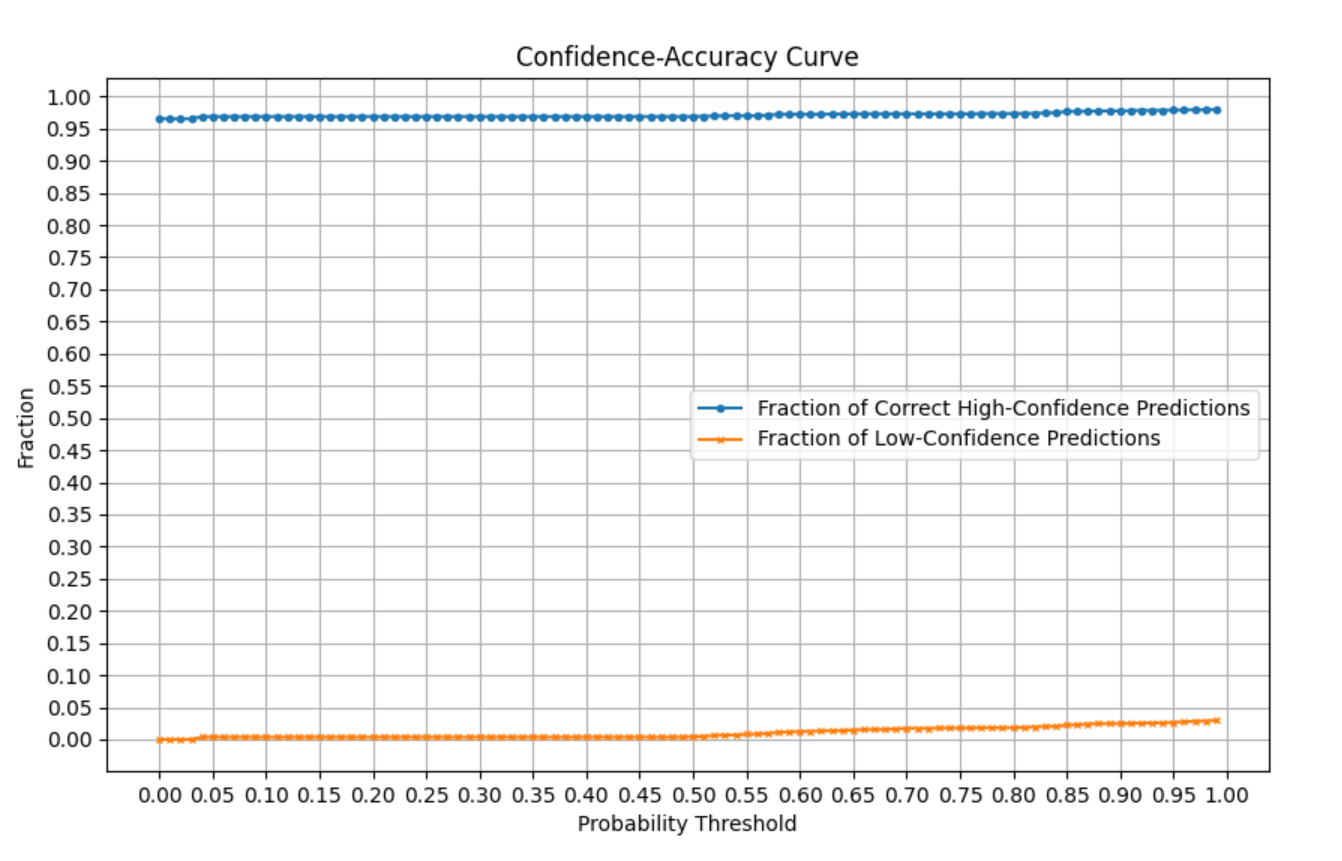

Modra ciara zobrazuje accuracy na test sete pre predikcie, kde je probability > threshold. Oranzova ukazuje podiel vzoriek, kde je probability < threshold. Inak povedane, modra ciara ukazuje aku mame presnost na vzorkach, kde ma model vysoke sebavedomie; oranzova ukazuje podiel, vzoriek kde si model nie je isty. Vseobecne plati, ze ak zvysujeme pozadovany threshold tak sa bude zvysovat accuracy (modra ciara stupa), ale zaroven zvysovat podiel vzoriek, kde confidence modelu nesplna tento threshold (rastie oranzova ciara).

Je vidiet, ze accuracy je celkovo velmi vysoka a pocet vzoriek, kde sme si neisty je velmi nizky. To je dobry vysledok (obzvlast na to, ze sme pouzily jednoduchy model bez akehokolvek fine-tuningu). Inak povedane, zvysovanim thresholdu nezlepsime zasadne accuracy, volba je preto trochu arbitrarna. Ako rule-of-thumb v tychto pripadoch (kedy na grafe nie su ziadne zasadne schody) pouzivam hranicu 0.8

Dovod rychleho a dobreho vysledku som uz naznacil - mame mnozstvo sablonovitych textov, model preto vseobecne nema problem zatriedit dokument. Je to trochu zradny vysledok, pretoze ak sa v novych vzorkach vyskytne novy text (ci uz uplne novy, alebo sa podobna sablona pouzije na inu kategoriu dokumentov) - nevieme ako sa model zachova. Ocakavame, ze predikovana probability bude nizsia, v praxi to ale nemusi byt pravda. Na testovacej vzorke je navyse velmi malo dokumentov, kde je probability mensia ako 1. Preto budeme pri ostrej predikcii vyuzivat aj dalsie kontrolne mechanizmy a nespoliehat len na probability vratenu modelom.

Okrem celkovej accuracy nas zaujimaju systematicke chyby. V classification_report pozrieme, ktore triedy su rozoznavane spravne a ktore nie:

| Label            | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| -1               | 0.25      | 1.00   | 0.40     | 3       |
| -3               | 0.50      | 1.00   | 0.67     | 1       |
| 5758             | 1.00      | 1.00   | 1.00     | 286     |
| 5759             | 1.00      | 1.00   | 1.00     | 48      |
| 5766             | 0.89      | 0.79   | 0.84     | 85      |
| 5771             | 1.00      | 1.00   | 1.00     | 162     |
| 5776             | 1.00      | 1.00   | 1.00     | 59      |
| 5779             | 1.00      | 1.00   | 1.00     | 40      |
| 5784             | 0.96      | 1.00   | 0.98     | 22      |
| 5785             | 1.00      | 1.00   | 1.00     | 18      |
| 5788             | –         | –      | –        | 0       |
| 5789             | 0.98      | 1.00   | 0.99     | 183     |
| 5792             | 1.00      | 0.50   | 0.67     | 2       |
| 5793             | 0.97      | 0.99   | 0.98     | 137     |
| 5794             | 0.97      | 1.00   | 0.98     | 30      |
| 5796             | 0.94      | 0.96   | 0.95     | 192     |
| 5797             | 1.00      | 0.67   | 0.80     | 3       |
| 5798             | 0.62      | 0.50   | 0.55     | 16      |
| 5830             | 1.00      | 1.00   | 1.00     | 97      |
| 5871             | 1.00      | 0.20   | 0.33     | 5       |
| 5887             | 0.84      | 0.97   | 0.90     | 33      |
| 5915             | 1.00      | 1.00   | 1.00     | 9       |
| 7330             | 1.00      | 1.00   | 1.00     | 5       |
| 7332             | 0.80      | 1.00   | 0.89     | 4       |
| 7336             | 0.96      | 0.93   | 0.94     | 27      |
| 7417             | 0.00      | –      | –        | 0       |
| 7496             | 0.50      | 0.50   | 0.50     | 2       |
| 7499             | 1.00      | 1.00   | 1.00     | 529     |
| viacero príloh   | 0.89      | 0.85   | 0.87     | 191     |
| **micro avg**    | 0.97      | 0.97   | 0.97     | 2189    |
| **macro avg**    | 0.86      | 0.88   | 0.86     | 2189    |
| **weighted avg** | 0.97      | 0.97   | 0.97     | 2189    |


Tu vidime, ze niektore triedy su bezproblemove:
5758, 5759, 5771, 5776, 5779, 5784, 5785, 5789, 5793, 5794, 5796, 5830, 5915, 7330, 7332, 7336, 7499

Naopak ine maju f1-score vyrazne pod celkovy priemer.
Niektore su pocetnejsie a stoja za hlbsiu analyzu: 5766, 5798, 5887, viacero príloh
Dalsie su malo pocetne, tam by som moc casu nestracal: 5797, 5792, 5871, 7496


V confusion_matrix (vid mlflow UI) pozrieme, ci su tieto triedy systematicky zamienane za ine (bud preto ze su podobne, alebo su vo vzorke rovnake textacie oznacene roznymi triedami).

5766 je najcastejsie zamienane s 5887 (nizky recall pri 5766 je z vacsej casti sposobeny nizkou precision pri 5887) 
5798 je najcastejsie zamienane s 'viacero priloh'

V identifikovanych pripadoch by urcite stalo za manualnu inspekciu zle urcenych dokumentov. Vid artifact 'most_common_errors' a 'all_errors' v mlflow.

Dalsi uzitocny krok je pozriet sa na predikovanu pravdepodobnost zle urcenych dokumentov. Confidence-accuracy graf nam naznacuje, ze si tym moc nepomozeme, ale je mozne ze aspon cas chyb eliminujeme ak zamietneme predikcie s nizkou pravdepodobnostou (ak sa skutocne jedna o tie, ktore su castejsie chybne)

Bud sa s chybami zmierime (zlucime ich do jednej triedy a posleme na manual), alebo sa pokusime identifikovat dovod tohto rozdielu. Podla toho mozeme pouzit ine predspracovanie, alebo text zkratit, alebo rozsekat na viac mensich textov. Neexistuje jeden recept, postup zavysi od analyzy problemu.

# 5) CLUSTERING
Trenovanie modelu je nezavisly pristup a ak akceptujem mieru chyb, ktore sme videli, je najjednoduchsi a najpriamociarejsi. Preco teda riesit clustering?

Dovody vidim dva:
1) Heterogenita tried
    Vysledky vieme vyhodnotit na urovni jednotlivych tried. Ku kazdej triede vsak mozeme mat mnoho roznych textacii. V pripade ze je jedna z nich je oznacena v trenovacich datach dvoma roznymi triedami uvidime ako problematicku celu triedu. Pripadne sa tento problem strati kvoli nizsiemu relativnemu zastupeniu tychto textov. Clustering naopak rozozna vsetky rozne textacie a umozni nam ich vyhodnotit samostatne. V kombinacii s modelom potom uvidime, ze jedna textacia je modelom vyhodnotena ako 2 rozne triedy (alebo ma znizenu pravepodobnost, alebo vysoku podobnost k ostatnym triedam, pouzitelnych metrik je mnoho). 

2) Manualna kontrola velkeho poctu textov za malu snahu
    Ak model spravi chybu a zaroven oplyva vysokou confidence, nemusime tuto chybu vobec detekovat. Je nerealne prekontrolovat kazdu predikciu manualne, ale urobit to len pre zastupcu kazdeho clusteru je schodne.

Pre uzitocny clustering je teda potrebnych niekolko veci:
1) maly pocet clusterov
    Velky pocet znemoznuje manualnu kontrolu
2) homogenne clustre
    Tato poziadavka je protichodne poziadavke c. 1. Cim viac homogenne clustere, tym vacsi pocet clusterov
3) meranie podobnosti textov - to nam umozni hned niekolko veci:
    - meranie podobnosti v ramci clustru - niektore clustere su si viac podobne nez ine. Potrebujeme metriku, ktorou identifikujeme mieru homogennosti clustrov
    - podobnost medzi clustermi - ak je cluster velmi podobny inemu, je na mieste byt opatrny => vacsia pravdepodobnost prelinajucich sa clustrov a chybneho zatriedenia
    - texty nezaradene do ziadneho clustru mozu byt stale dostatocne podobne niektorym textom, aby sme ich k nim priradili manualne

Poziadavku 1 a 2 vyriesime hyperoptimalizaciou na trenovacej vzorke.
Poziadavku 3 vyriesime pripravou meracich funkcii, ktore nam vyhodnotia podobnost dvoch textov/clustrov

In [ ]:
# Pre clustrovanie pouzivam algoritmus DBSCAN:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
# Dva hlavne parametre su eps a min_samples. Eps je maximalna vzdialenost medzi dvoma bodmi, aby boli zaradene do jedneho clustra. Min_samples je minimalny pocet bodov v okoli bodu, aby bol bod povazovany za core point. Obidva parametre su sucastou hyperoptimalizacie.
# Pre vyhodnotenie clustrovania nas zaujima primarne homogenita, tj kazdy cluster by mal obsahovat len jednu triedu
# https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
# Pre SLSP som zvolil eps = 0.12, min_samples = 3

from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.metrics import homogeneity_score
from sklearn.model_selection import ParameterGrid

# Sample data with known labels
y = df.label
X = model.clf.estimator['vect'].transform(df.ProcessedText) # Potrebujeme pracovat s vektorizovanymi datami, nie s textami


# Define parameter grid
param_grid = {
    'eps': [0.05, 0.1, 0.2],
    'min_samples': [3, 10,20]
}

best_score = -1
best_params = None

# Grid search loop
for params in ParameterGrid(param_grid):
    db = DBSCAN(**params).fit(X)
    labels = db.labels_

    # Skip noise-only clustering
    if len(set(labels)) <= 1 or all(l == -1 for l in labels):
        continue

    
    score = homogeneity_score(y[labels != -1], labels[labels != -1])
    print(f"Params: {params}, Homogeneity: {score:.4f}, Clusters: {len(set(labels))}, Noise: {sum(l == -1 for l in labels)}")

    if score > best_score:
        best_score = score
        best_params = params

# best_eps = 0.12
# best_min_samples = 3

In [ ]:
# Produkcny dataset som uz zavesil na mlflow server, odtial pokracujeme preprocessingom a clustrovanim:
target_dataset = mltools.data.datareader_from_mlflow_run(name = 'Spisy_PB_18abc_21a_24a', version = 1)
target_dataset['ProcessedText'] = preprocessor.predict(target_dataset.df.Text)  
target_vects = model.clf.estimator['vect'].transform(target_dataset.df.ProcessedText)
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(target_vects)
cluster_count = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

# 6) Predikcia na novych datach + kontrolne mechanizmy

Su vytvorene clustre homogenne? Dokaze ich model spravne zatriedit? Ktore clustre je potrebne prezriet detailne?

Na zodpovedanie tychto otazok ziskame pomocne metriky. Fantazii sa medze nekladu, tu je nejaky vyber:
- maximalna pravdepodobnost pre vzorky v clustri - tj najvyssia pravdepodobnost vratena modelom zo vsetkych vzoriek pre vsetky triedy v clustri
- minimalna maximalna pravdepodobost pre vzorky v clustri - pre kazdu vzorku vybereme pravdepodobnost pre najpravdepodobnejsiu triedu a z tohto vyberu vybereme najmensie cislo. Tj v tomto clustri si je model aspon takto isty svojou predikciou pre akukolvek vzorku.
- maximalna vzdialenost v ramci clustru - cosine_similarity aj RandomForest pracuje s vektorizovanymi textami - cosine_similarity a pravdepodobnost teda budu dost korelovat, ale nejaka nova informacia tam je
- predikcie modelu pre vzorky v clustri
- predikcie modelu s pravdepodobnostou nad threshold (0.8), ostatne oznacene ako -1 - to co sa podla predikcii moze javit ako heterogenny cluster moze byt len nizka confidence modelu - tu to uvidime
- prvych 100 znakov v jednom z vybratych textov

Pre kazdy cluster vyhodnotime tieto hodnoty. To nam umozni identifikovat clustre, ktorym mozeme verit (vysoka proba, nizka within-cluster vzdialenost)

In [ ]:
# Tieto funkcie casom presunieme do mltools, zatial takto:
import numpy as np
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

def parallel_map(func, data, num_workers=8, **kwargs):
    '''
    Vypocty vzdialenosti skaluju N^2, preto je vhodne pouzit paralelizaciu. 
    '''
    import multiprocessing
    import functools

    try:
        multiprocessing.set_start_method("fork", force = True)
    except RuntimeError:
        pass

    func_with_kwargs = functools.partial(func, **kwargs)

    """Runs a function in parallel using multiprocessing.Pool with fork."""
    with multiprocessing.Pool(processes=num_workers) as pool:
        results = pool.map(func_with_kwargs, data)
    return results

def maximum_within_cluster_cosine_distance(cluster_number : int):
    '''
    vects - TFIDF vektorizovane texty
    clusters - clustre z DBSCAN
    '''
    global vects
    global clusters
    subset = vects[clusters == cluster_number]
    distances =  np.zeros((subset.shape[0],subset.shape[0]))
    for idx in range(subset.shape[0]):
        for idx2 in range(idx):
            if idx != idx2:
                distances[idx, idx2] = 1 - cosine_similarity(subset[idx], subset[idx2])
    return np.max(distances)


In [ ]:
from copy import copy

model_predictions = np.array(model.predict(target_dataset.df.ProcessedText))
model_probas = model.predict_proba(target_dataset.df.ProcessedText)
model_confident_predictions = copy(model_predictions)
model_predictions[model_probas.max(axis=1) < 0.8] = 'low-confidence'

cluster_predictions = [Counter(model_predictions[clusters == i]) for i in range(cluster_count)]
cluster_confident_predictions = [Counter(model_confident_predictions[clusters == i]) for i in range(cluster_count)]
cluster_max_within_cluster_distances = parallel_map(maximum_within_cluster_cosine_distance, range(cluster_count))
cluster_max_probas = [np.max(model_probas[clusters == i]) for i in range(cluster_count)]
cluster_minmax_probas = [model_probas[clusters == i].max(axis=1).min() for i in range(cluster_count)]
cluster_first_text_excerpt = [target_dataset.df.ProcessedText[clusters == i].iloc[0][:100] for i in range(cluster_count)]
minimum_text_length = [target_dataset.df.ProcessedText[clusters == i].min() for i in range(cluster_count)]

cluster_analysis = pd.DataFrame({
    'Cluster': range(cluster_count),
    'LabelDistribution': cluster_predictions,
    'ConfidentLabelDistribution': cluster_confident_predictions,
    'MaxWithinClusterDistance': cluster_max_within_cluster_distances,
    'MaxProba': cluster_max_probas,
    'MinMaxProba': cluster_minmax_probas,
    'FirstTextExcerpt': cluster_first_text_excerpt,
    'MinimumTextLength' : minimum_text_length
})

# Vysledny prehlad mozeme prehladne pozriet v exceli
cluster_analysis.to_clipboard()

Interpretacia vysledkov je trade-off medzi spolahlivostou a mierou manualnej kontroly. Cim zhodnejsie su metriky pre kazdy cluster, tym menej manualnej kontroly potrebujeme.

- LabelDistribution - ak zoznam obsahuje len 1 kategoriu, je to argument za homogenny cluster
- ConfidentLabelDistribution - ak LabelDistribution obsahuje viac kategorii, ale tento vysledok obsahuje jednu kategoriu + nejake s oznacenim "low-confidence" znamena to, ze rozdielne predikcie boli z dovodu nizkej pravdepodobnosti a cluster je pravdepodobne homogenny
- MaxWithinClusterDistance - Tato vzdialenost nie je limitovana hranicou pouzitou pri clustrovani (parameter eps), vid princip DBSCANu. Male cislo implikuje homogenny cluster. Velke cislo indikuje roznorodejsi cluster, ktoreho prvky nie su blizke inym clustrom, ale nema jednoznacnu implikaciu. Co je male cislo je heuristika, ako rule of thumb sa da pouzit 2x eps.
- MaxProba - Videli sme mnoho predikcii s pravdepodobnostou 1.0, takze tu cakame podobne cisla. Cluster s nizkym cislom moze indikovat uplne novy typ textu
- MinMaxProba - miera homogenity z pohladu modelu. Vysoke cislo indikuje, ze model vsetky texty v clustri urcuje jednoznacne. Male cislo indikuje, ze clustrovanie zaclenilo texty do jedneho clustru, ale z pohladu modelu je medzi nimi vyrazny rozdiel - napriek tomu ze obidva vypocty su zalozene na TFIDF vektorizacii. Typicky indikuje dlhe texty, ktore su z pohladu cosine_similarity velmi podobne ale dostatocne sa lisia na to, aby to RandomForest zachytil - napriklad multilabel dokument zlozeny z dlhej zmluvy + kratkej zmienky o RPMN.
- FirstTextExcerpt - rychly sanity check pre porovnanie predikcie modelu s (pravdepodobne) reprezentativnym textom
- MinimumTextLength - velmi kratke texty (typicky necitatelne dorucenky, 'zle nascanovane', etc.) su sami o sebe podozrive a aj v pripade legitimnych textoch nachylne na nestabilne predikcie. Clustre s malou hodnotou si zasluzia manualnu inspekciu

Ak sme clustrovanie spravili spravne, ziskame velky pocet clustrov, ktore su jednoznacne zaclenene spravne a maly pocet clustrov, ktore su heterogenne (a mozno zatriedene spravne) a/alebo zatriedene nespravne/nespolahlivo. Tieto vyzaduju manualnu inspekciu, pripadne m clustrovanie v ramci clustru pre detekciu heterogenity, etc. Okrem toho ziskame nejaky pocet vzoriek, ktore neboli zaclenene do ziadneho clustru. Tie mozeme opat procesovat bud manualne, alebo s pomocou dalsich metrik.

## ANALYZA NEZACLENENYCH VZORIEK

Nezaclenene vzorky nemusia splnovat podmienky dane hyperparametrami (eps, min_samples), ale mozu byt stale relativne blizko ku clustrom. Podobnost ku clustrom mozeme dalej vyuzit tak, ze najdeme najpodobnejsi cluster a mieru podobnosti. Pouzitim heuristickych thresholdov si mozeme usetrit velke mnostvo manualnej prace.

Zaroven mozeme pouzit dalsie metriky - cosine similarity je rychla, ale spolieha na TFIDF vektorizaciu, ktora nie je robustna voci chybovemu OCR. Pre cosine_similarity maju slova 'kategoria' a 'kateg0ria' a 'kategorie' nulovu podobnost.
Ako alternativu mozeme pouzit fuzzy porovnanie textu. Tento vypocet je pomalsi, ale velmi robustny voci chybovemu OCR.

Pre nezatriedene texty preto mozeme zmerat podobnost k existujucim clustrom roznymi sposobmi:
- cosine_similarity (klasika) na vektorizovanych preprocesovanych textoch
- fuzz_similarity na povodnych textoch
- fuzz_similarity na prvych 1000 znakoch povodnych textoch - focus na zaciatok dokumentu

In [ ]:
# Casom presuniem tuto funkcionalitu do mltools, zatial takto:

from sklearn.metrics.pairwise import cosine_similarity
from rapidfuzz import fuzz

def max_cosine_similarity(text : str, cluster_number : int):
    '''
    Find a text in cluster cluster_number that is the most similar to the provided text. Cosine similarity used as a metric.

    Parameters
    __________
    text : str
        Text to compare
    cluster_number : int
        Cluster to search in

    Required global variables:
    __________________________
    vects : np.array
        TFIDF vectorized texts
    clusters : np.array
        Clustering results
    
    Returns
    _______
    max_value : float
        Maximum cosine similarity
    max_idx : int
        Index from the clustered dataset of the most similar text in the cluster
    '''
    global vects
    global clusters
    sims = cosine_similarity(model.clf.estimator['vect'].transform([text]),vects[clusters == cluster_number])
    max_value = np.max(sims)
    max_idx = np.where(clusters == cluster_number)[0][np.argmax(sims)]
    return max_value, max_idx

def max_fuzz_similarity(text, cluster_number, texts_to_use):
    '''
    Find a text in cluster cluster_number that is the most similar to the provided text. Fuzzy matching used as a metric.

    Parameters
    __________
    text : str
        Text to compare
    cluster_number : int
        Cluster to search in
    texts_to_use : np.array
        Array of texts to compare to. This is useful when we want to use the same clustering results but compare to the original / preprocessed / truncated / etc. texts
    
    Required global variables:
    __________________________
    clusters : np.array
        Clustering results

    Returns
    _______
    max_value : float
        Maximum fuzzy similarity
    max_idx : int
        Index from the clustered dataset of the most similar text in the cluster
    '''
    global clusters
    sims = [fuzz.token_sort_ratio(text,cluster_text) for cluster_text in texts_to_use[clusters == cluster_number]]
    max_value = np.max(sims)
    max_idx = np.where(clusters == cluster_number)[0][np.argmax(sims)]
    return max_value, max_idx

def best_cluster_match(text, texts_to_use, metric = 'cosine'):
    '''
    Find the best cluster match for a text, i.e. run max_cosine_similarity or max_fuzz_similarity for all clusters and return the best match.

    Parameters
    __________
    text : str
        Text to compare
    metric : str
        Metric to use. 'cosine' for cosine similarity, anything else for fuzzy matching
    texts_to_use : np.array
        Array of texts to compare to. This is useful when we want to use the same clustering results but compare to the original / preprocessed / truncated / etc. texts

    Returns
    _______
    max_value : float
        Maximum similarity
    max_idx : int
        Index of the best cluster match
    sims : np.array
        Array of similarities for all clusters
    '''
    max_cluster_number = max(np.unique(clusters))

    def max_fuzz_length_similarity_with_texts(text, cluster_number):
        return max_fuzz_similarity(text, cluster_number, texts_to_use)

    metric = max_cosine_similarity if metric == 'cosine' else max_fuzz_length_similarity_with_texts
    sims = np.array([metric(text, i)[0] for i in range(max_cluster_number + 1)])
    return np.max(sims), np.argmax(sims), sims

In [ ]:
orig_texts = target_dataset.df.Text.to_numpy()
truncated_texts = np.array([x[:1000] for x in target_dataset.df.Text])

unclustered_texts_count = len(df.index[clusters == -1])

highest_cosine_similarities = []
similar_cosine_clusters = []
highest_fuzz_similarities = []
similar_fuzz_clusters = []
highest_fuzz_1000_similarities = []
similar_fuzz_1000_clusters = []
processing_counter = 0
for unclustered_text_idx in df.index[clusters == -1]:
    processing_counter += 1
    unclustered_text = orig_texts[unclustered_text_idx]
    print(f'Calculating similarities for text number {processing_counter} / {unclustered_texts_count})')
    best_sim, best_cluster, all_sims = best_cluster_match(unclustered_text, target_vects, metric = 'cosine')
    highest_cosine_similarities.append(best_sim)
    similar_cosine_clusters.append(best_cluster)
    best_sim, best_cluster, all_sims = best_cluster_match(unclustered_text, truncated_texts, metric = 'fuzz')
    highest_fuzz_similarities.append(best_sim)
    similar_fuzz_clusters.append(best_cluster)
    best_sim, best_cluster, all_sims = best_cluster_match(unclustered_text, truncated_texts, metric = 'fuzz')
    highest_fuzz_1000_similarities.append(best_sim)
    similar_fuzz_1000_clusters.append(best_cluster)
    # all_sims mozeme pouzit na inspekciu, ci je text podobny aj dalsim clustrom

def similar_cluster_model_prediction(cluster_number):
    '''
    Vyber najcastejsiu triedu v clustri.
    POZOR NA HETEROGENNE CLUSTRE!
    '''
    model_predictions_for_cluster = Counter(model_predictions[clusters == cluster_number]).keys()
    return max(model_predictions_for_cluster, key = model_predictions_for_cluster.get)

unclustered_texts_df = pd.DataFrame({
    'Text': orig_texts[clusters == -1],
    'CosineSimilarity': highest_cosine_similarities,
    'CosineCluster': similar_cosine_clusters,
    'LabelCosineSimilarCluster' : [similar_cluster_model_prediction(i) for i in similar_cosine_clusters],
    'FuzzSimilarity': highest_fuzz_similarities,
    'FuzzCluster': similar_fuzz_clusters,
    'LabelFuzzSimilarCluster' : [similar_cluster_model_prediction(i) for i in similar_fuzz_clusters],
    'Fuzz1000Similarity': highest_fuzz_1000_similarities,
    'Fuzz1000Cluster': similar_fuzz_1000_clusters,
    'Fuzz1000SimilarCluster' : [similar_cluster_model_prediction(i) for i in similar_fuzz_1000_clusters],
    'TextLength' : [len(text) for text in orig_texts[clusters == -1]]
})

unclustered_texts_df.to_clipboard()
    

Tato analyza nam moze pomoct zredukovat pocet textov poslanych na manual. Ostre hranice neexistuju, opat je potrebne zvolit vhodny tradeoff.
Pri SLSP viacmenej platilo nasledovne:
- ak je podobnost CosineSimilarity alebo FuzzSimilarity > 0.8, mozeme text povazovat za clena clustru
- ak je podobnost aspon jednej z metrik CosineSimilarity alebo FuzzSimilarity > 0.6 alebo 0.7, jedna sa s velkou pravdepodobnostou o text podobny clustru. Treba uz ale pocitat s chybami
- Vysoka hodnota Fuzz1000Similarity ale nizka hodnota FuzzSimilarity implikuje vysoku podobnost zaciatku dokumentu, ale nizku podobnost v neskorsej casti dokumentu. Dovody mozu byt rozne - od detailov zmluvy/vypisu z uctu pre dokumenty v jednej triede az po single vs multilabel dokument
- vsetky nizke hodnoty (pod 0.6) indikuju jedinecny a malopocetny text (podobnych textov je menej ako min_samples)
- ak je TextLength kratky je lepsia manualna inspekcia


POZOR:
- Je uzitocnejsie sa pozerat na LabelXXXSimilarCluster namiesto XXXCluster, pretoze jedna metrika moze ukazat ze najpodobnejsi je cluster A, druha ze najpodobnejsi je cluster B, ale pritom su to dva clustre, ktore patria do rovnakej kategorie.Ak to tak je, v XXXCluster uvidime ine cisla clustrov, ale v LabelXXXSimilarCluster uvidime rovnaku predikciu.
- Label*SimilarCluster vybera najpocetnejsiu triedu v clustri. V pripade heterogennych clustrov moze byt tato informacia zavadzajuca!
- velmi kratke